# Create a linear model in keras

In [1]:
%matplotlib inline
from __future__ import division,print_function
import os, json
from glob import glob
import numpy as np
import scipy
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt
import utils; reload(utils)
from utils import plots, get_batches, plot_confusion_matrix, get_data

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


In [2]:
from numpy.random import random, permutation
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential
from keras.layers import Input
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop
from keras.preprocessing import image

## Create input and output for the model

In [ ]:
x = random((30, 2))

In [ ]:
y = np.dot(x, [2., 3.]) + 1

In [ ]:
x[:5]

In [ ]:
y[:5]

In [ ]:
lm = Sequential([Dense(1, input_shape=(2,))])
lm.compile(optimizer=SGD(lr=0.1), loss='mse')

### Check the preexisting loss function for x, y

In [ ]:
lm.evaluate(x,y)

### Fit the model to minimise the loss function for x and y using gradient descent

In [ ]:
lm.fit(x, y, nb_epoch=5, batch_size=1)

In [ ]:
lm.get_weights()

In [ ]:
lm.evaluate(x,y)

## Creating a linear model on predictions

First we like always create our untrained VGG model and get the data from the training and validation folders. Before that we set the paths obviously.

In [3]:
path='data/dogscats/'
# path='data/dogscats/sample/'
model_path=path + 'model/'
if not os.path.exists(model_path): os.mkdir(model_path)

In [4]:
from vgg16 import Vgg16
vgg = Vgg16()
model = vgg.model

In [5]:
#Setting the batch size to be large because we are crazy like that
batch_size=64

In [6]:
batches=get_batches(path+'train/', shuffle=False, batch_size=1)
val_batches=get_batches(path+'valid/', shuffle=False, batch_size=1)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


Using functions that concatenate all the batches so that we can save the entire array and dont have to proces the images everytime

In [7]:
train_data = get_data(path+"train/")
val_data = get_data(path+'valid/')

Found 23000 images belonging to 2 classes.


KeyboardInterrupt: 

Defining functions to save the arrays. We will be using the python library bcolz for that

In [6]:
import bcolz
def save_array(fname, arr): c=bcolz.carray(arr, rootdir=fname, mode='w'); c.flush()
def load_array(fname): return bcolz.open(fname)[:]

In [ ]:
val_data.shape

In [ ]:
save_array(model_path+'train_data.bc', train_data)
save_array(model_path+'val_data.bc', val_data)

In [7]:
val_data=load_array(model_path+'val_data.bc')
train_data=load_array(model_path+'train_data.bc')

In [8]:
val_batches.classes

NameError: name 'val_batches' is not defined

Now we have to encode the classes of the VGG model

In [10]:
def onehot(x): return np.array(OneHotEncoder().fit_transform(x.reshape(-1, 1)).todense())

In [12]:
trn_classes=batches.classes
val_classes=val_batches.classes
#Saving the classes
# save_array(model_path+'train_classes_sample.bc', trn_classes)
# save_array(model_path+'val_classes_sample.bc', val_classes)


NameError: name 'batches' is not defined

In [14]:
trn_classes=load_array(model_path+'train_classes.bc')
val_classes=load_array(model_path+'val_classes.bc')
# #Now we one hot encode the classes
trn_labels=onehot(trn_classes)
val_labels=onehot(val_classes)

In [18]:
trn_features=model.predict(train_data, batch_size=64)
val_features=model.predict(val_data, batch_size=64)

In [19]:
save_array(model_path+'trn_lastlayer_features.bc', trn_features)
save_array(model_path+'val_lastlayer_features.bc', val_features)

In [15]:
trn_features=load_array(model_path+'trn_lastlayer_features.bc')
val_features=load_array(model_path+'val_lastlayer_features.bc')

## Constructing the linear model

In [ ]:
lm=Sequential([Dense(2, activation='softmax', input_shape=(1000,))])
lm.compile(optimizer=RMSprop(lr=0.1), loss='categorical_crossentropy', metrics=['accuracy'])

In [40]:
print(trn_labels)


[[ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]]


In [15]:
lm.fit(trn_features, trn_labels, nb_epoch=3, batch_size=batch_size, validation_data=(val_features, val_labels))

Train on 23000 samples, validate on 2000 samples
Epoch 1/3
23000/23000 [==============================] - 0s - loss: 0.0958 - acc: 0.9686 - val_loss: 0.0944 - val_acc: 0.9695
Epoch 2/3
23000/23000 [==============================] - 0s - loss: 0.0782 - acc: 0.9757 - val_loss: 0.1057 - val_acc: 0.9675
Epoch 3/3
23000/23000 [==============================] - 0s - loss: 0.0785 - acc: 0.9774 - val_loss: 0.1003 - val_acc: 0.9765


In [22]:
lm.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_4 (Dense)                  (None, 2)             2002        dense_input_1[0][0]              
Total params: 2002
____________________________________________________________________________________________________


## Things to Visualise
* Correct random predictions

In [16]:
# We need the classes predict ( to compare with val_labels)
preds = lm.predict_classes(val_features, batch_size=64)
#we also need the probabilities as they need to be bisualised on each of the image
probs =  lm.predict_proba(val_features, batch_size=64)

1728/2000 [========================>.....] - ETA: 0s

In [36]:
probs

array([[  8.0037e-01,   1.9963e-01],
       [  1.0000e+00,   4.1421e-26],
       [  9.0802e-01,   9.1983e-02],
       ..., 
       [  1.3634e-03,   9.9864e-01],
       [  3.1300e-07,   1.0000e+00],
       [  1.1573e-04,   9.9988e-01]], dtype=float32)

In [21]:
#probs has probability of both cats and dogs. We just need it for the cats, so we will get the first column only
probs = probs[:,0]

In [40]:
probs

array([  8.0037e-01,   1.0000e+00,   9.0802e-01, ...,   1.3634e-03,   3.1300e-07,   1.1573e-04], dtype=float32)

In [17]:
filenames = val_batches.filenames

In [18]:
#method to plot
def plots_idx(idx, titles=None):
    plots([image.load_img(path+'valid/'+filenames[i]) for i in idx], titles=titles)

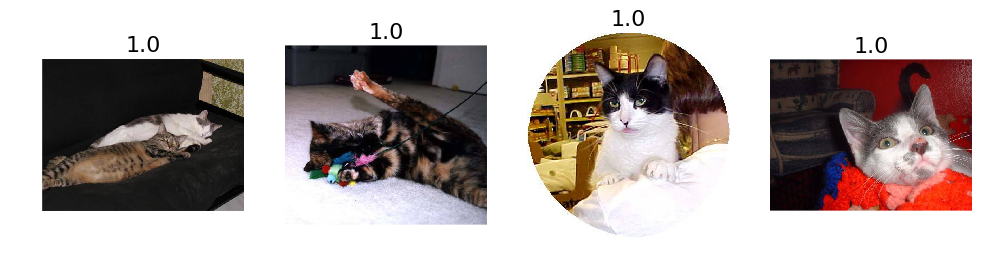

In [22]:
correct = np.where(preds==val_labels[:,1])[0]
idx = permutation(correct)[:4]
plots_idx(idx, probs[idx])

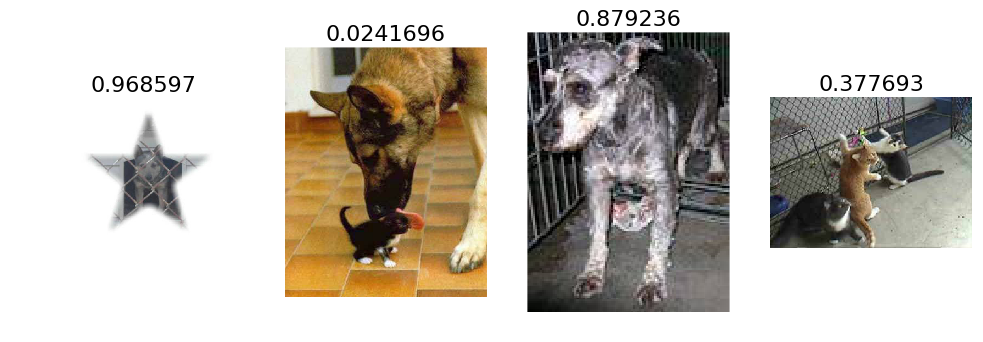

In [24]:
#next we plot some incorrect predictions
incorrect = np.where(preds!=val_labels[:,1])[0]
idx = permutation(incorrect)[:4]
plots_idx(idx, probs[idx])

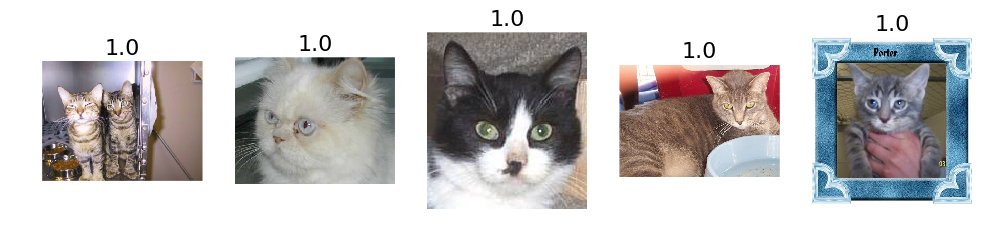

In [28]:
#next we plot the cats which we the model was most correct about
correct_cats = np.where((preds==0) & (preds==val_labels[:,1]))[0]
most_correct_cats = np.argsort(probs[correct_cats])[::-1][:5]
plots_idx(correct_cats[most_correct_cats], probs[correct_cats][most_correct_cats])

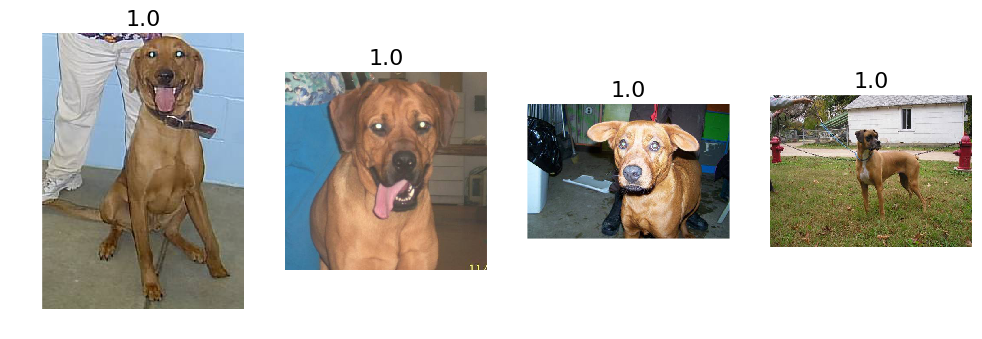

In [32]:
#next we plot the dogs where the model was most correct about
correct_dogs = np.where((preds==1) & (preds==val_labels[:,1]))[0]
most_correct_dogs = np.argsort(probs[correct_dogs])[:4]
plots_idx(correct_dogs[most_correct_dogs], 1-probs[correct_dogs][most_correct_dogs])

In [33]:
most_correct_dogs

array([945, 642, 794, 346])

In [36]:
probs[correct_dogs][most_correct_dogs]

array([  2.7270e-11,   2.9508e-11,   4.4067e-10,   1.5525e-09], dtype=float32)

In [37]:
x = np.array([1,2,3,4])

In [39]:
correct_x = np.where( x > 2)[0]

In [40]:
x[correct_x]

array([3, 4])

In [16]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  1792        zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_1[0][0]            
___________________________________________________________________________________________

In [17]:
model.pop()

In [18]:
for layer in model.layers:
    layer.trainable=False

In [22]:
model.add(Dense(2, activation="softmax"))

In [23]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  0           zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_1[0][0]            
___________________________________________________________________________________________

In [33]:
batches.N

23000

In [25]:
gen = image.ImageDataGenerator()

In [30]:
batches = gen.flow(train_data, trn_labels, batch_size=64, shuffle=True)
val_batches = gen.flow(val_data, val_labels, batch_size=64, shuffle=True)

In [34]:
def fit_model(model, batches, val_batches, nb_epoch=1):
    model.fit_generator(batches, samples_per_epoch=batches.N, nb_epoch=nb_epoch, validation_data=val_batches, nb_val_samples=val_batches.N )

In [35]:
opt=RMSprop(lr=0.01)

In [36]:
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [37]:
fit_model(model, batches, val_batches, nb_epoch=6)

Epoch 1/6
23000/23000 [==============================] - 625s - loss: 0.3471 - acc: 0.9710 - val_loss: 0.2686 - val_acc: 0.9780
Epoch 2/6
23000/23000 [==============================] - 622s - loss: 0.3365 - acc: 0.9751 - val_loss: 0.2604 - val_acc: 0.9805
Epoch 3/6
23000/23000 [==============================] - 637s - loss: 0.3301 - acc: 0.9761 - val_loss: 0.2505 - val_acc: 0.9825
Epoch 4/6
23000/23000 [==============================] - 1080s - loss: 0.3089 - acc: 0.9781 - val_loss: 0.2996 - val_acc: 0.9765
Epoch 5/6
23000/23000 [==============================] - 1072s - loss: 0.3435 - acc: 0.9761 - val_loss: 0.2676 - val_acc: 0.9820
Epoch 6/6
23000/23000 [==============================] - 674s - loss: 0.3204 - acc: 0.9783 - val_loss: 0.2644 - val_acc: 0.9810


In [38]:
model.save_weights(model_path+"fintune6.h5")